In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(100,100).view(-1,1,100,100)
        self._to_linear = None
        self.convs(x)
        
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 256) 
        self.fc3 = nn.Linear(256,29)

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x)) # bc this is our output layer. No activation here.
        x = self.fc3(x)
        return F.softmax(x, dim=1)

In [3]:
model = Net()
model.load_state_dict(torch.load('initial_model'))
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=10368, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=29, bias=True)
)

In [4]:
LABELS = {}
LABELS2 = {}
for i in enumerate(['H','E','L','O','W','R','D','space','del','nothing']):
    LABELS[i[0]]=i[1]
    LABELS2[i[1]]=i[0]
print(LABELS,LABELS2)

{0: 'H', 1: 'E', 2: 'L', 3: 'O', 4: 'W', 5: 'R', 6: 'D', 7: 'space', 8: 'del', 9: 'nothing'} {'H': 0, 'E': 1, 'L': 2, 'O': 3, 'W': 4, 'R': 5, 'D': 6, 'space': 7, 'del': 8, 'nothing': 9}


In [5]:
new_data = []
for i in os.listdir('new_data'):
    for f in tqdm(os.listdir('new_data/'+i)):
        path = f'new_data/{i}/{f}'
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (100,100))
        new_data.append([np.array(img)/255,LABELS[i]])



FileNotFoundError: [Errno 2] No such file or directory: 'new_data'

In [8]:
new_data_imgs = torch.Tensor([i[0] for i in new_data]).view(-1,100,100)
new_labels =[i[1] for i in new_data]

In [9]:
correct = 0 
total = 0 
with torch.no_grad():
    for i in tqdm(range(len(new_data_imgs))):
        real_class = new_labels[i]
        net_out = model(new_data_imgs[i].view(-1,1,100,100))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct+=1
            plt.imshow(new_data_imgs[i], cmap="gray")
            plt.title(f'Real label:{LABELS[new_labels[i]]} pred label:{LABELS[(int(predicted_class))]}')
            plt.pause(0.2)
        else:
            pass
        total+=1
    print('Accuracy:',round(correct/total,3))
            
    
    

0it [00:00, ?it/s]


ZeroDivisionError: division by zero

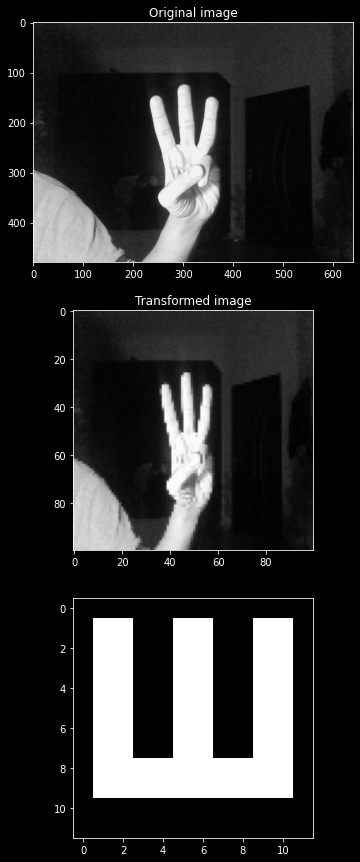

In [6]:
matrix = {4:[[0,0,0,0,0,0,0,0,0,0,0,0],
[0,1,1,0,0,1,1,0,0,1,1,0],
[0,1,1,0,0,1,1,0,0,1,1,0],
[0,1,1,0,0,1,1,0,0,1,1,0],
[0,1,1,0,0,1,1,0,0,1,1,0],
[0,1,1,0,0,1,1,0,0,1,1,0],
[0,1,1,0,0,1,1,0,0,1,1,0],
[0,1,1,0,0,1,1,0,0,1,1,0],
[0,1,1,1,1,1,1,1,1,1,1,0],
[0,1,1,1,1,1,1,1,1,1,1,0],
[0,0,0,0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0,0,0,0]]}
def convert_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (100,100))/255
    img = torch.Tensor(img).view(-1,1,100,100)
    return img
plt.style.use("dark_background")
fig, axes = plt.subplots(3,1,figsize=(15,15))
img_path='/home/tarun/Pictures/Webcam/2021-02-21-055543.jpg'
converted_image = convert_image(img_path)
axes[0].imshow(cv2.imread(img_path,cv2.IMREAD_GRAYSCALE),cmap="gray")
axes[1].imshow(converted_image[0][0],cmap="gray")
axes[0].set_title("Original image")
axes[1].set_title("Transformed image")

prediction = torch.argmax(model(converted_image))
axes[2].imshow(matrix[prediction.item()],cmap="gray")

In [11]:
correctly_classified = []
incorrectly_classified = []
for i in os.listdir('new_data'):
    for f in tqdm(os.listdir('new_data/'+i)):

        if LABELS2[i] == int(torch.argmax(model(feed_img(f'new_data/{i}/{f}')))):
            correctly_classified.append(f'new_data/{i}/{f}')
        else:
            incorrectly_classified.append(f'new_data/{i}/{f}')
        

FileNotFoundError: [Errno 2] No such file or directory: 'new_data'

In [169]:
len(correctly_classified)

84

In [170]:
len(incorrectly_classify)

30

In [171]:
correctly_classified

['new_data/R/frame-5.jpg',
 'new_data/R/frame-1.jpg',
 'new_data/R/frame-2.jpg',
 'new_data/R/frame-29.jpg',
 'new_data/R/frame-6.jpg',
 'new_data/R/frame-4.jpg',
 'new_data/R/frame-0.jpg',
 'new_data/R/frame-15.jpg',
 'new_data/R/frame-3.jpg',
 'new_data/E/frame-5.jpg',
 'new_data/E/frame-19.jpg',
 'new_data/E/frame-8.jpg',
 'new_data/E/frame-23.jpg',
 'new_data/E/frame-18.jpg',
 'new_data/E/frame-11.jpg',
 'new_data/E/frame-28.jpg',
 'new_data/E/frame-20.jpg',
 'new_data/E/frame-17.jpg',
 'new_data/E/frame-29.jpg',
 'new_data/E/frame-10.jpg',
 'new_data/E/frame-21.jpg',
 'new_data/E/frame-22.jpg',
 'new_data/E/frame-6.jpg',
 'new_data/E/frame-13.jpg',
 'new_data/E/frame-4.jpg',
 'new_data/E/frame-16.jpg',
 'new_data/E/frame-14.jpg',
 'new_data/E/frame-7.jpg',
 'new_data/E/frame-15.jpg',
 'new_data/E/frame-27.jpg',
 'new_data/E/frame-12.jpg',
 'new_data/E/frame-9.jpg',
 'new_data/L/frame-5.jpg',
 'new_data/L/frame-19.jpg',
 'new_data/L/frame-8.jpg',
 'new_data/L/frame-1.jpg',
 'new_da

In [154]:
LABELS[0]

'H'